<a href="https://de.linkedin.com/in/delafuenteaguilerapablo/de-de"><img src="https://media-exp1.licdn.com/dms/image/C4D03AQElWBXe___WeQ/profile-displayphoto-shrink_200_200/0?e=1609372800&v=beta&t=IdUiY7Y78vTI3jcLbSWUboqDUTKDU2XgKg4KPptmGVY" width="200" align="right"></a>

# Capstone Project - The Battle of Neighborhoods (Week 1)

## Project from Pablo de la Fuente Aguilera
### I´m an engineer and you can see my full background on my Linkedin profile: https://de.linkedin.com/in/delafuenteaguilerapablo/de-de
### This Notebook is part of the Capstone Project.
### This Project is the last Assignment of the IBM Professional Certificate in Data Science, offered by Coursera.org

Importing Libraries

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans
import folium

print('Libraries successfully imported.')

Libraries successfully imported.


## We present the Problem

We can suppose that we are thinking about opening a exotic restaurant in Manhattan, more specifically a Japanese or Asiatic one. This could be a good business opportunity but we need to carry out a market research in order to establish a long-term success.

To start with, we will analyse the existing restaurants of this category in Manhattan. And we will sort them by neighborhood, in order to identify the best possible location.



## Downloading the data about New York City



In [4]:
# The data was downloaded with the name newyork_data.json
# wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


We create a Dataframe with the downloaded data

In [5]:
neighborhoods_data = newyork_data['features']
# We define the columns of the dataframe
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# We start and initialize the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough, 'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat, 'Longitude': neighborhood_lon}, ignore_index=True)
# We show the Dataframe
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


We use geopy to take the coordinates of New York City

In [6]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of New York City are {}, {}.'.format(latitude, longitude))

The coordinates of New York City are 40.7127281, -74.0060152.


## We analyze of the neighborhoods in Manhattan

In [7]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


We create a map using Folium

In [8]:
import folium
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Borough'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## We start taking Venues of the Neighborhood using Foursquare

In [9]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [10]:
LIMIT = 500 
radius = 5000 
CLIENT_ID = 'VMMI5O32REHM4WANU2TGS2WES3NKUKYDSKVFX3URVLHTVGJP' # The Foursquare ID
CLIENT_SECRET = 'P50THBFK4CC0GZA2QBRD5CUNDAT5AX1IHF0MLSKJTNONGUSV' # The Foursquare Secret
VERSION = '20181020'

We take the venues in Manhattan of Japanese and Sushi Restaurants

In [11]:
neighborhoods = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
newyork_venues_sushi = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d1d2941735')
newyork_venues_sushi.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Planet Tokyo,40.886233,-73.909479,Sushi Restaurant
1,Chinatown,40.715618,-73.994279,Nakaji,40.715912,-73.996597,Sushi Restaurant
2,Chinatown,40.715618,-73.994279,Shinsen,40.715608,-73.996611,Japanese Restaurant
3,Chinatown,40.715618,-73.994279,Bondi Bar,40.721247,-73.996264,Sushi Restaurant
4,Chinatown,40.715618,-73.994279,Whole Foods Sushi Bar,40.724000,-73.992277,Sushi Restaurant


In [12]:
print("To answer the question How many Sushi Restaurants are there in Manhattan?")
newyork_venues_sushi.shape

To answer the question How many Sushi Restaurants are there in Manhattan?


(1100, 7)

We use a map to show them

In [13]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

map_newyork_sushi = folium.Map(location=[latitude, longitude], zoom_start=10)
addToMap(newyork_venues_sushi, 'red', map_newyork_sushi)

map_newyork_sushi


We create a Dataframe to sumarize all this venues into Neighborhoods

In [14]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0

manhattan_grouped = newyork_venues_sushi.groupby('Neighborhood').count()
manhattan_grouped

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,22,22,22,22,22,22
Carnegie Hill,24,24,24,24,24,24
Central Harlem,4,4,4,4,4,4
Chelsea,44,44,44,44,44,44
Chinatown,24,24,24,24,24,24
Civic Center,32,32,32,32,32,32
Clinton,38,38,38,38,38,38
East Harlem,4,4,4,4,4,4
East Village,49,49,49,49,49,49


In [15]:
print('There are {} uniques categories.'.format(len(newyork_venues_sushi['Venue Category'].unique())))

There are 21 uniques categories.


## Analysis of every Neighborhood

In [16]:

manhattan_onehot = pd.get_dummies(newyork_venues_sushi[['Venue Category']], prefix="", prefix_sep="")

manhattan_onehot['Neighborhood'] = newyork_venues_sushi['Neighborhood'] 

fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Asian Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant,Indian Chinese Restaurant,Japanese Restaurant,Noodle House,Ramen Restaurant,Restaurant,Sake Bar,Sandwich Place,Seafood Restaurant,Smoothie Shop,Steakhouse,Sushi Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
0,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Chinatown,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [17]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Asian Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant,Indian Chinese Restaurant,Japanese Restaurant,Noodle House,Ramen Restaurant,Restaurant,Sake Bar,Sandwich Place,Seafood Restaurant,Smoothie Shop,Steakhouse,Sushi Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
0,Battery Park City,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.090909,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.818182,0.045455,0.000000
1,Carnegie Hill,0.041667,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.041667,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.750000,0.000000,0.041667
2,Central Harlem,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,1.000000,0.000000,0.000000
3,Chelsea,0.045455,0.000000,0.000000,0.000000,0.000,0.022727,0.000000,0.000000,0.000000,0.113636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.795455,0.000000,0.022727
4,Chinatown,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.875000,0.000000,0.000000
5,Civic Center,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.062500,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.875000,0.031250,0.000000
6,Clinton,0.026316,0.000000,0.026316,0.026316,0.000,0.000000,0.000000,0.000000,0.000000,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.00,0.000000,0.789474,0.000000,0.000000
7,East Harlem,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,1.000000,0.000000,0.000000
8,East Village,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.061224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.918367,0.000000,0.020408
9,Financial District,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.850000,0.000000,0.000000


We sort the venues by Neighborhoods

In [18]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Sushi Restaurant,Japanese Restaurant,Noodle House,Theme Restaurant,Indian Chinese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market
1,Carnegie Hill,Sushi Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Indian Chinese Restaurant,Asian Restaurant,Seafood Restaurant,Sandwich Place,Sake Bar,Restaurant,Ramen Restaurant
2,Central Harlem,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
3,Chelsea,Sushi Restaurant,Japanese Restaurant,Asian Restaurant,Fish Market,Vegetarian / Vegan Restaurant,Seafood Restaurant,Sandwich Place,Sake Bar,Restaurant,Ramen Restaurant
4,Chinatown,Sushi Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant


We start clustering neighborhoods and merging them into 5 clusters

In [19]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,0,Sushi Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,3,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant


We create a map with the clusters. Here we can appreciate the neighborhood in Manhattan and the resulting clusters 

In [74]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-3],
        fill=True,
        fill_color=rainbow[-4],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters

Cluster Nr 0

In [21]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Sushi Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
11,Roosevelt Island,Sushi Restaurant,Asian Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
19,East Village,Sushi Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
21,Tribeca,Sushi Restaurant,Noodle House,Theme Restaurant,Indian Chinese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store
22,Little Italy,Sushi Restaurant,Japanese Restaurant,Noodle House,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
23,Soho,Sushi Restaurant,Japanese Restaurant,Noodle House,Theme Restaurant,Indian Chinese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market
24,West Village,Sushi Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Sake Bar,Fish Market,Asian Restaurant,Sandwich Place,Seafood Restaurant,Restaurant,Ramen Restaurant
27,Gramercy,Sushi Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
31,Noho,Sushi Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
32,Civic Center,Sushi Restaurant,Japanese Restaurant,Noodle House,Theme Restaurant,Indian Chinese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market


Cluster Nr 1

In [22]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Manhattan Valley,Sushi Restaurant,Japanese Restaurant,Hawaiian Restaurant,Vegetarian / Vegan Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store
26,Morningside Heights,Sushi Restaurant,Japanese Restaurant,Hawaiian Restaurant,Vegetarian / Vegan Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store


Cluster Nr 2

In [23]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Sushi Restaurant,Japanese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Smoothie Shop,Hawaiian Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega
9,Yorkville,Sushi Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Indian Chinese Restaurant,Asian Restaurant,Seafood Restaurant,Sandwich Place,Sake Bar,Restaurant,Ramen Restaurant
10,Lenox Hill,Sushi Restaurant,Asian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Smoothie Shop,Hawaiian Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega
13,Lincoln Square,Sushi Restaurant,Japanese Restaurant,Smoothie Shop,Chinese Restaurant,Grocery Store,Vegetarian / Vegan Restaurant,Indian Chinese Restaurant,Bakery,Cocktail Bar,Deli / Bodega
14,Clinton,Sushi Restaurant,Japanese Restaurant,Asian Restaurant,Chinese Restaurant,Seafood Restaurant,Cocktail Bar,Indian Chinese Restaurant,Bakery,Deli / Bodega,Fish Market
15,Midtown,Sushi Restaurant,Asian Restaurant,Seafood Restaurant,Japanese Restaurant,Restaurant,Bakery,Ramen Restaurant,Vegetarian / Vegan Restaurant,Sandwich Place,Sake Bar
16,Murray Hill,Sushi Restaurant,Japanese Restaurant,Asian Restaurant,Restaurant,Bakery,Ramen Restaurant,Vegetarian / Vegan Restaurant,Sake Bar,Sandwich Place,Seafood Restaurant
17,Chelsea,Sushi Restaurant,Japanese Restaurant,Asian Restaurant,Fish Market,Vegetarian / Vegan Restaurant,Seafood Restaurant,Sandwich Place,Sake Bar,Restaurant,Ramen Restaurant
20,Lower East Side,Sushi Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
28,Battery Park City,Sushi Restaurant,Japanese Restaurant,Noodle House,Theme Restaurant,Indian Chinese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market


Cluster Nr 3

In [24]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
2,Washington Heights,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
3,Inwood,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
4,Hamilton Heights,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
5,Manhattanville,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
6,Central Harlem,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
7,East Harlem,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Grocery Store,Hawaiian Restaurant
18,Greenwich Village,Sushi Restaurant,Sake Bar,Japanese Restaurant,Vegetarian / Vegan Restaurant,Indian Chinese Restaurant,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market


Cluster Nr 4

In [25]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Upper West Side,Sushi Restaurant,Japanese Restaurant,Asian Restaurant,Grocery Store,Bakery,Chinese Restaurant,Cocktail Bar,Deli / Bodega,Fish Market,Hawaiian Restaurant


We finish here the analysis

As a conclussion: the marked areas are the best to open this kind of restaurant:


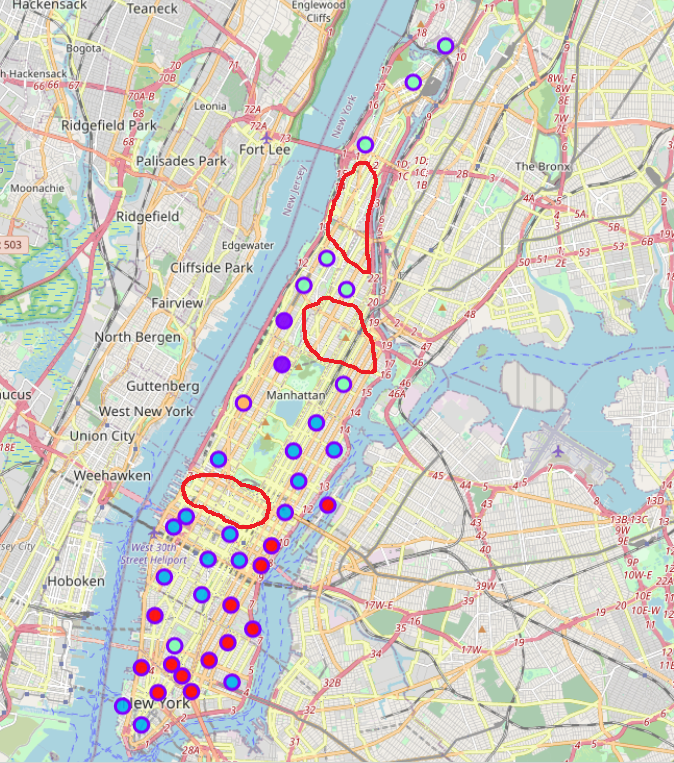

In [26]:
from IPython.display import Image
print("As a conclussion: the marked areas are the best to open this kind of restaurant:")
Image("Result_Analysis_Manhattan.png")